In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
url = "data/amz_uk_price_prediction_dataset.csv"
df = pd.read_csv(url)

In [3]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


Parte 1: Análisis de las tendencias de los productos más vendidos en las distintas categorías de productos
Objetivo : Comprender la relación entre las categorías de productos y su estatus de best-seller.

1. Análisis de tabla cruzada :

- Crear una tabla cruzada entre el producto `category` y el `isBestSeller` estado.

In [4]:
cross_tab = pd.crosstab(df["category"], df["isBestSeller"])
cross_tab

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


- ¿Existen categorías en las que ser un best-seller es más frecuente?

Sugerencia: una opción es calcular la proporción de best-sellers para cada categoría y luego ordenar las categorías según esta proporción en orden descendente.

In [5]:
# Crear una nueva columna con la proporción de best-sellers
cross_tab["proportion_best_sellers"] = cross_tab[True] / (cross_tab[False] + cross_tab[True])
# Ordenar las categorías por proporción de best-sellers
sorted_cross_tab = cross_tab.sort_values(by = "proportion_best_sellers" , ascending = False)
sorted_cross_tab


isBestSeller,False,True,proportion_best_sellers
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


2. Pruebas estadísticas :

- Realice una prueba de Chi-cuadrado para determinar si la distribución de los más vendidos es independiente de la categoría del producto

In [6]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(cross_tab)  #necesita la cross table

chi2_statistic, chi2_p_value

#Hay una pequeña correlacion

(36684.23786636857, 0.0)

- Calcule la V de Cramér para comprender la fuerza de asociación entre el estado de best-seller y la categoría.

In [7]:
from scipy.stats.contingency import association

cross_tab1 = pd.crosstab(df["category"], df["isBestSeller"])

# Computing the association between variables in 'cross_tab' using the "cramer" method
association(cross_tab1, method="cramer")
#Hay una fuerta asociacion entre las dos variables

0.1222829439760564

3. Visualizaciones :

- Visualice la relación entre las categorías de productos y el estado de mayor venta utilizando un gráfico de barras apiladas.

<Axes: xlabel='category'>

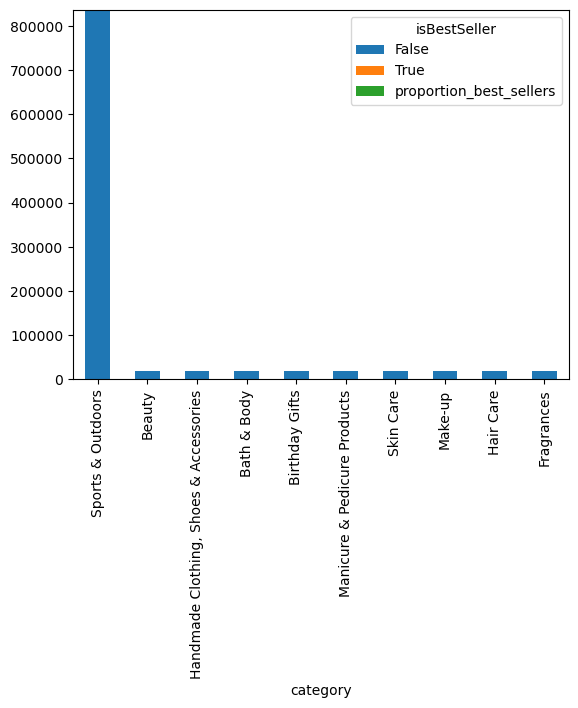

In [8]:
import matplotlib.pyplot as plt

# Selecciona las principales categorías (por ejemplo, las 10 primeras)
top_categories = cross_tab.sum(axis = 1).nlargest(10).index
cross_tab_top = cross_tab.loc[top_categories]

cross_tab_top.plot(kind = "bar", stacked = True)


Parte 2: Exploración de precios y calificaciones de productos en distintas categorías y marcas
Objetivo : Investigar cómo las diferentes categorías de productos influyen en los precios de los productos.

0. Paso preliminar: eliminar valores atípicos en los precios de los productos.

Para este fin, podemos utilizar el método IQR (rango intercuartil). Los productos cuyo precio sea inferior al primer cuartil menos 1,5 veces el IQR o superior al tercer cuartil más 1,5 veces el IQR se considerarán valores atípicos y se eliminarán del conjunto de datos. Los siguientes pasos se realizarán con el marco de datos sin valores atípicos.

Sugerencia: puede consultar la última verificación de comprensión al final de la lección Análisis bivariado de EDA para obtener una pista sobre cómo hacer esto.

In [19]:
q1 = df["price"].quantile(0.25)
q3 = df["price"].quantile(0.75)
IQR  =  q3 - q1

#definir outliers
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


1. Parcelas de violín :

Utilice un gráfico de violín para visualizar la distribución de price los distintos productos categories. Filtre las 20 categorías principales en función del recuento para una mejor visualización.

C:\Users\Bapa\AppData\Local\Temp\ipykernel_8248\606478356.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='category', y='price', data=filtered_top_categories, inner='quartile', palette='muted')


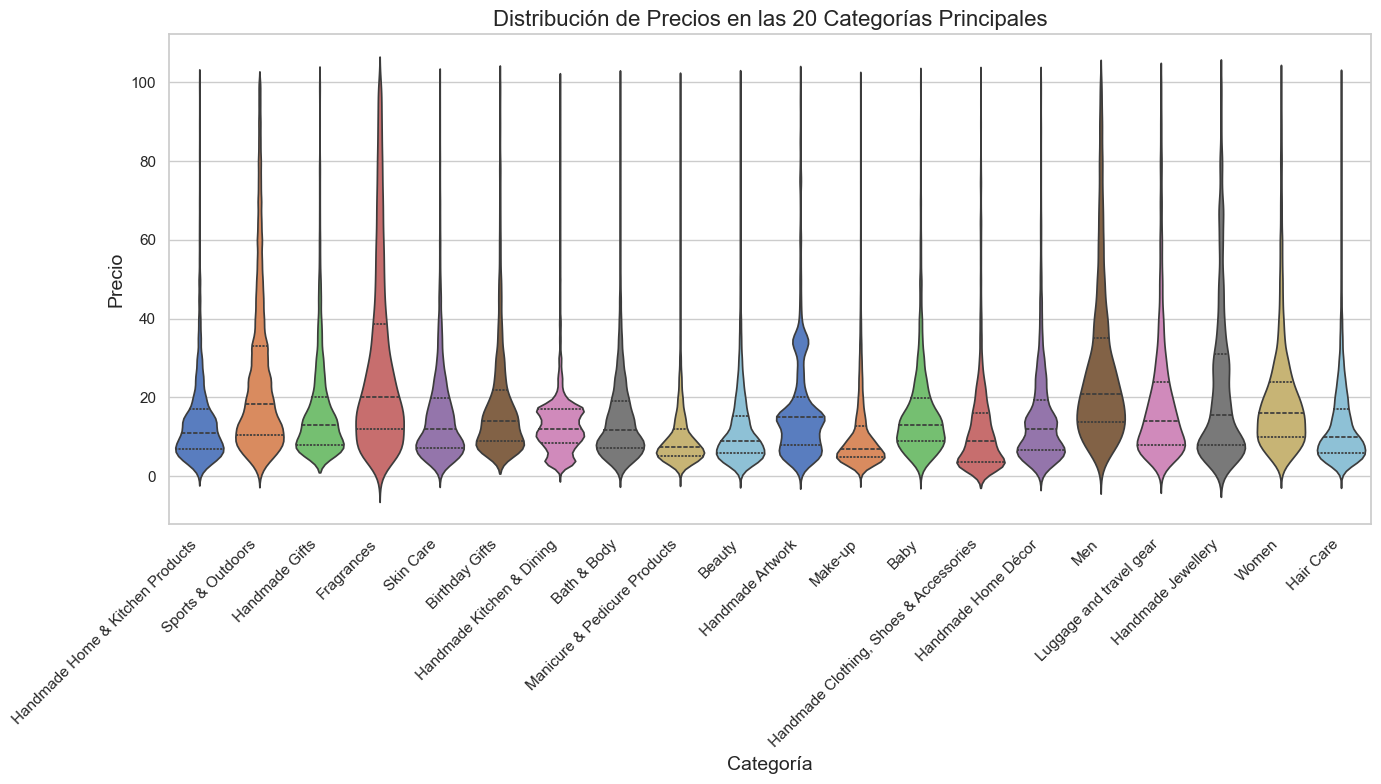

In [20]:
top_categories = df_filtered['category'].value_counts().head(20).index

# Filtrar el DataFrame para que solo contenga las 20 categorías principales
filtered_top_categories = df_filtered[df_filtered['category'].isin(top_categories)]

# Paso 3: Visualizar la distribución de precios con un gráfico de violín
plt.figure(figsize=(14, 8))
sns.violinplot(x='category', y='price', data=filtered_top_categories, inner='quartile', palette='muted')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
plt.title('Distribución de Precios en las 20 Categorías Principales', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Precio', fontsize=14)
plt.tight_layout()  # Ajustar el diseño para evitar superposición
plt.show()

2. Cree un gráfico de barras que compare el precio promedio de los productos para las 10 categorías de productos principales (según el recuento).
¿Qué categoría de producto tiene el precio promedio más alto? No filtre aquí por categorías principales.

In [35]:
mean_price_by_category = df.groupby('category')['price'].mean().reset_index()

# Renombrar la columna de la media para mayor claridad
mean_price_by_category.rename(columns={'price': 'mean_price'}, inplace=True)

# Ordenar el DataFrame por 'mean_price' de forma descendente y seleccionar las 10 principales
top_10_categories = mean_price_by_category.sort_values('mean_price', ascending=False).head(10)
top_10_categories

,category,mean_price
165,Laptops,1087.987827
0,3D Printers,1018.036129
75,Desktop PCs,926.816064
141,Home Office Furniture,622.135898
278,Test & Measurement,559.382973
134,Home Audio Record Players,529.665585
39,CPUs,514.519317
76,Digital Cameras,496.156185
178,Material Handling Products,487.191813
108,Graphics Cards,444.746827


C:\Users\Bapa\AppData\Local\Temp\ipykernel_8248\1650066981.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='mean_price', data=top_10_categories, palette='viridis')


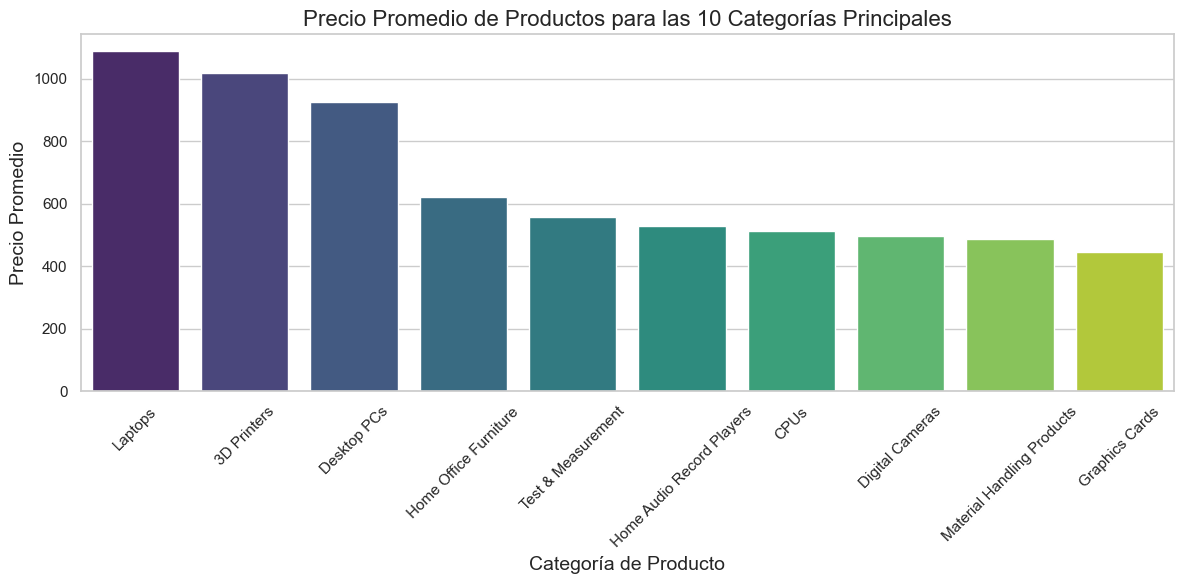

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='mean_price', data=top_10_categories, palette='viridis')
plt.title('Precio Promedio de Productos para las 10 Categorías Principales', fontsize=16)
plt.xlabel('Categoría de Producto', fontsize=14)
plt.ylabel('Precio Promedio', fontsize=14)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visibilidad
plt.tight_layout()  # Ajustar el diseño
plt.show()

C:\Users\Bapa\AppData\Local\Temp\ipykernel_8248\3738768047.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='stars', data=filtered_df, palette='Set2')


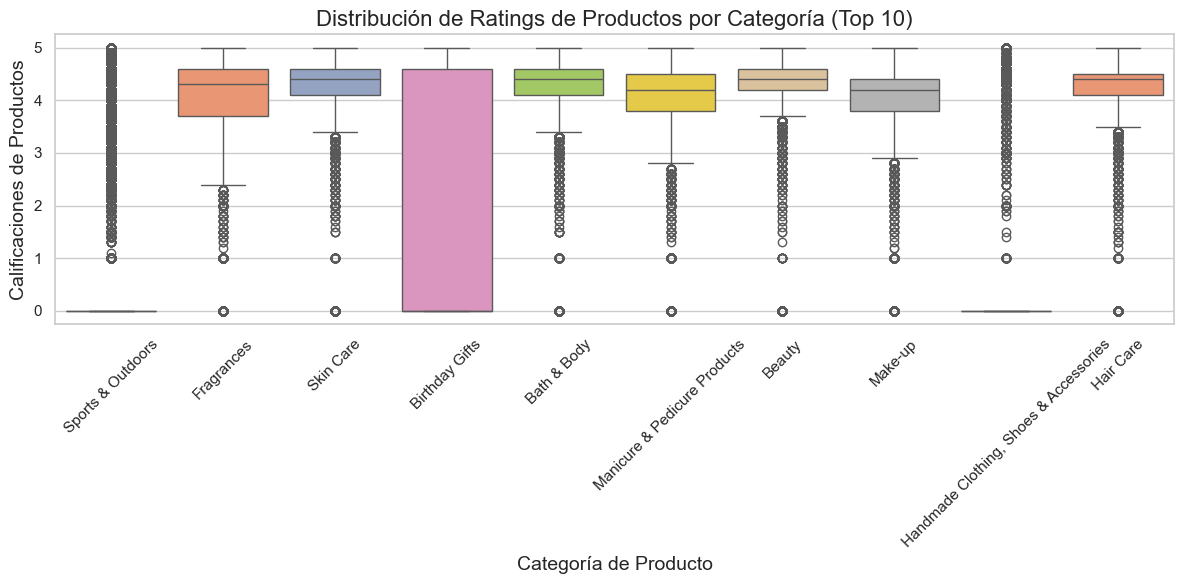

In [38]:

top_categories = df['category'].value_counts().head(10).index

# Paso 2: Filtrar el DataFrame para que solo contenga las 10 categorías principales
filtered_df = df[df['category'].isin(top_categories)]

# Paso 3: Crear el diagrama de caja
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='stars', data=filtered_df, palette='Set2')
plt.title('Distribución de Ratings de Productos por Categoría (Top 10)', fontsize=16)
plt.xlabel('Categoría de Producto', fontsize=14)
plt.ylabel('Calificaciones de Productos', fontsize=14)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visibilidad
plt.tight_layout()  # Ajustar el diseño
plt.show()


Parte 3: Investigación de la interacción entre los precios y las calificaciones de los productos
Objetivo : Analizar cómo las calificaciones de los productos (stars) se correlacionan con los precios de los productos.

1. Coeficientes de correlación :

Calcular el coeficiente de correlación entre price y stars.

In [40]:
correlation = df["price"].corr(df["stars"])
correlation

-0.12490673262159059

2. Visualizaciones :

Utilice un diagrama de dispersión para visualizar la relación entre la calificación del producto y el precio. ¿Qué patrones puede observar?
Utilice un mapa de calor de correlación para visualizar las correlaciones entre todas las variables numéricas.
Examine si los precios de los productos suelen seguir una distribución normal utilizando un gráfico QQ.

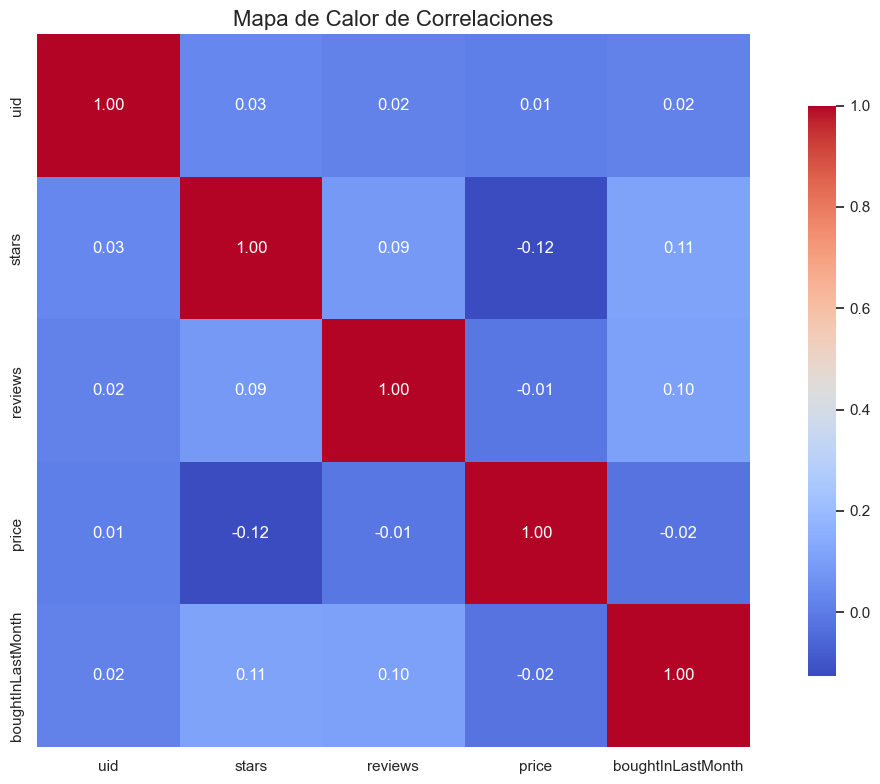

In [43]:

numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Paso 2: Calcular la matriz de correlación para las columnas numéricas
correlation_matrix = numeric_df.corr()

# Paso 3: Crear un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Mapa de Calor de Correlaciones', fontsize=16)
plt.tight_layout()  # Ajustar el diseño
plt.show()
